In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 27s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_42.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(42, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.666305,92.098570,89.729737,91.790236,92.226629,91.502295
공시지가(만원),75.047147,80.313305,74.846738,78.852508,78.059009,77.423741
year_linear,63.521352,63.250525,64.580640,64.283279,64.526651,64.032489
건축년도,50.437386,48.353293,46.829052,49.325853,48.189168,48.626950
전용면적,36.259078,38.420910,40.918271,37.030822,34.428492,37.411514


In [13]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.666305,92.098570,89.729737,91.790236,92.226629,91.502295
공시지가(만원),75.047147,80.313305,74.846738,78.852508,78.059009,77.423741
year_linear,63.521352,63.250525,64.580640,64.283279,64.526651,64.032489
건축년도,50.437386,48.353293,46.829052,49.325853,48.189168,48.626950
전용면적,36.259078,38.420910,40.918271,37.030822,34.428492,37.411514
ynorm,30.318798,31.229665,31.435159,29.590870,29.881214,30.491141
xy,21.078881,22.026681,18.634365,23.023101,20.955739,21.143753
x_2nd,19.380858,17.571474,19.273309,19.551680,18.427705,18.841005
주건축물수,12.155295,13.258588,13.652012,13.213066,12.814597,13.018712
층mean,10.340482,10.321457,10.139596,10.453713,11.114674,10.473984


In [14]:
top_41_df = shap_summary_df.iloc[:41,:]
print(top_41_df.shape)

(41, 6)


In [15]:
top_41_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.666305,92.098570,89.729737,91.790236,92.226629,91.502295
공시지가(만원),75.047147,80.313305,74.846738,78.852508,78.059009,77.423741
year_linear,63.521352,63.250525,64.580640,64.283279,64.526651,64.032489
건축년도,50.437386,48.353293,46.829052,49.325853,48.189168,48.626950
전용면적,36.259078,38.420910,40.918271,37.030822,34.428492,37.411514


In [16]:
top_41_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
용도지역명1,4.562890,4.581319,4.327265,4.589605,4.193663,4.450949
층norm,3.787018,4.055723,3.580345,3.824727,3.859167,3.821396
부속건축물수,2.239972,3.987037,3.600130,2.925730,2.577549,3.066083
지구단위계획구역,2.905529,3.298885,2.999654,2.843215,3.053591,3.020175
도로접면,2.817238,2.462757,2.855905,2.750914,2.610058,2.699374
가축사육제한구역,2.571330,2.729709,2.628347,2.441996,2.526815,2.579640
부속건축물면적,2.252919,2.259671,3.178774,2.037450,2.586593,2.463081
지붕_평지붕_fraction,2.469521,2.497513,2.473370,2.527072,2.302287,2.453953
지형높이,2.462074,2.230820,2.387386,2.595621,2.493335,2.433847
month_sin,2.337809,2.199214,2.163926,2.372913,2.409045,2.296581


In [17]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [18]:
training_data_df = training_data_df[top_41_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 46)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,총건축면적,토지이동상황,호수대비연면적,xnorm,아파트지구,옥내자주식대수,호수대비부속건축물면적,호수대비주차수,층,총호수,y_2nd,용도지역명1,층norm,부속건축물수,지구단위계획구역,도로접면,가축사육제한구역,부속건축물면적,지붕_평지붕_fraction,지형높이,month_sin,건물나이,옥외자주식대수,층min,(한강)폐기물매립시설_설치제한지역,공원,지형형상,y_cos,y_sin,x_sin,x_cos,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,0.0,2,54.0,4.094180e+07,0,0.222222,0.0,0,0,0,0.0,1.0,0,-0.866025,0,0.0,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,0.0,2,54.0,4.094180e+07,0,0.222222,0.0,0,0,0,0.0,1.0,0,-0.500000,0,0.0,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,0.0,4,54.0,4.094180e+07,0,0.444444,0.0,0,0,0,0.0,1.0,0,0.000000,0,0.0,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,0.0,9,54.0,4.094180e+07,0,1.000000,0.0,0,0,0,0.0,1.0,0,0.866025,0,0.0,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,0.0,1,54.0,4.094180e+07,0,0.111111,0.0,0,0,0,0.0,1.0,0,-0.866025,0,0.0,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [19]:
from sklearn.model_selection import KFold, GroupKFold

In [20]:
import lightgbm as lgb

In [21]:
from sklearn.metrics import r2_score

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

12

In [24]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 41)
y dist plot


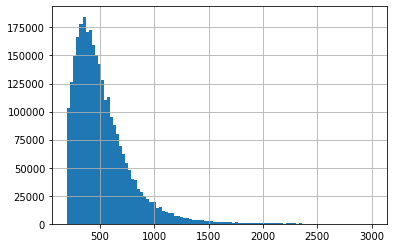

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5915
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.645
[100]	valid_0's huber: 64.8525
[150]	valid_0's huber: 58.698
[200]	valid_0's huber: 54.9324
[250]	valid_0's huber: 52.5359
[300]	valid_0's huber: 50.8406
[350]	valid_0's huber: 49.4945
[400]	valid_0's huber: 48.4175
[450]	valid_0's huber: 47.5598
[500]	valid_0's huber: 46.901
[550]	valid_0's huber: 46.1969
[600]	valid_0's huber: 45.5461
[650]	valid_0's huber: 44.941
[700]	valid_0's huber: 44.3658
[750]	valid_0's huber: 43.9189
[800]	valid_0's huber: 43.5208
[850]	valid_0's huber: 43.1178
[900]	valid_0's huber: 42.738
[950]	valid_0's huber: 42.4336
[1000]	valid_0's huber: 42.127
[1050]	valid_0's huber: 41.8318
[1100]	valid_0's huber: 41.5289
[1150]	valid_0's huber: 41.2681
[1200]	valid_0's huber: 41.0159
[1250]	valid_0's huber: 40.7869
[1300]	valid_0's huber: 40.5766
[1350]	valid_0's huber: 40.3857
[1400]	valid_0's huber: 40.1922
[1450]	valid_

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


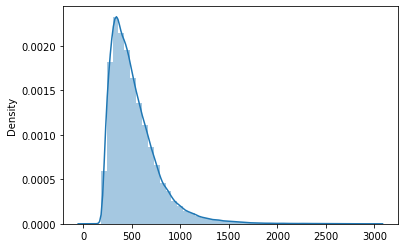

Fold 0 end
Fold 1 start
(2926581, 41)
y dist plot


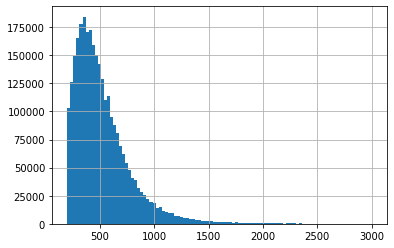

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5916
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6039
[100]	valid_0's huber: 64.8806
[150]	valid_0's huber: 58.6889
[200]	valid_0's huber: 55.0707
[250]	valid_0's huber: 52.5404
[300]	valid_0's huber: 50.7962
[350]	valid_0's huber: 49.4382
[400]	valid_0's huber: 48.3875
[450]	valid_0's huber: 47.4597
[500]	valid_0's huber: 46.749
[550]	valid_0's huber: 45.981
[600]	valid_0's huber: 45.2986
[650]	valid_0's huber: 44.7453
[700]	valid_0's huber: 44.183
[750]	valid_0's huber: 43.7036
[800]	valid_0's huber: 43.2222
[850]	valid_0's huber: 42.8612
[900]	valid_0's huber: 42.4596
[950]	valid_0's huber: 42.1298
[1000]	valid_0's huber: 41.8168
[1050]	valid_0's huber: 41.5185
[1100]	valid_0's huber: 41.2758
[1150]	valid_0's huber: 41.0367
[1200]	valid_0's huber: 40.8392
[1250]	valid_0's huber: 40.6227
[1300]	valid_0's huber: 40.4296
[1350]	valid_0's huber: 40.2388
[1400]	valid_0's huber: 40.0775
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


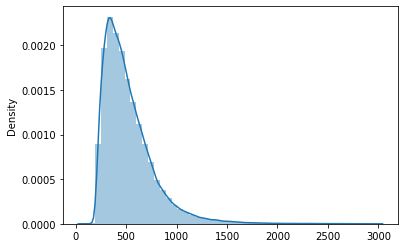

Fold 1 end
Fold 2 start
(2926581, 41)
y dist plot


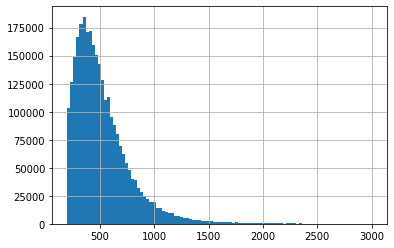

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5272
[100]	valid_0's huber: 64.9121
[150]	valid_0's huber: 58.7218
[200]	valid_0's huber: 55.1874
[250]	valid_0's huber: 52.6309
[300]	valid_0's huber: 50.9163
[350]	valid_0's huber: 49.5994
[400]	valid_0's huber: 48.3544
[450]	valid_0's huber: 47.4579
[500]	valid_0's huber: 46.6751
[550]	valid_0's huber: 45.8992
[600]	valid_0's huber: 45.2482
[650]	valid_0's huber: 44.672
[700]	valid_0's huber: 44.1161
[750]	valid_0's huber: 43.6107
[800]	valid_0's huber: 43.1836
[850]	valid_0's huber: 42.8545
[900]	valid_0's huber: 42.4659
[950]	valid_0's huber: 42.1706
[1000]	valid_0's huber: 41.8639
[1050]	valid_0's huber: 41.5334
[1100]	valid_0's huber: 41.2763
[1150]	valid_0's huber: 41.0251
[1200]	valid_0's huber: 40.769
[1250]	valid_0's huber: 40.5176
[1300]	valid_0's huber: 40.2912
[1350]	valid_0's huber: 40.0917
[1400]	valid_0's huber: 39.9058
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


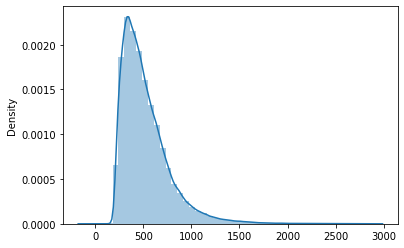

Fold 2 end
Fold 3 start
(2926581, 41)
y dist plot


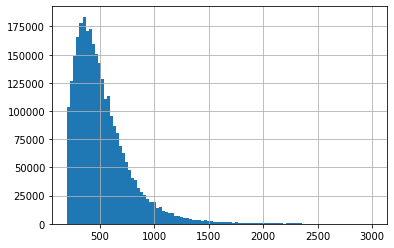

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5912
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4911
[100]	valid_0's huber: 64.7989
[150]	valid_0's huber: 58.641
[200]	valid_0's huber: 55.0194
[250]	valid_0's huber: 52.584
[300]	valid_0's huber: 50.8119
[350]	valid_0's huber: 49.5144
[400]	valid_0's huber: 48.3964
[450]	valid_0's huber: 47.4083
[500]	valid_0's huber: 46.4975
[550]	valid_0's huber: 45.8356
[600]	valid_0's huber: 45.2442
[650]	valid_0's huber: 44.7607
[700]	valid_0's huber: 44.2338
[750]	valid_0's huber: 43.7661
[800]	valid_0's huber: 43.2725
[850]	valid_0's huber: 42.8639
[900]	valid_0's huber: 42.546
[950]	valid_0's huber: 42.1952
[1000]	valid_0's huber: 41.9057
[1050]	valid_0's huber: 41.6021
[1100]	valid_0's huber: 41.3186
[1150]	valid_0's huber: 41.0478
[1200]	valid_0's huber: 40.7973
[1250]	valid_0's huber: 40.5463
[1300]	valid_0's huber: 40.3347
[1350]	valid_0's huber: 40.0955
[1400]	valid_0's huber: 39.8824
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


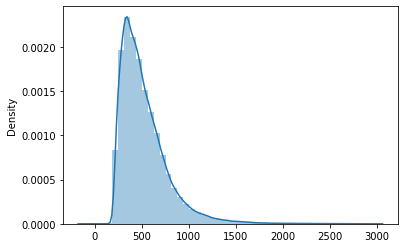

Fold 3 end
Fold 4 start
(2926581, 41)
y dist plot


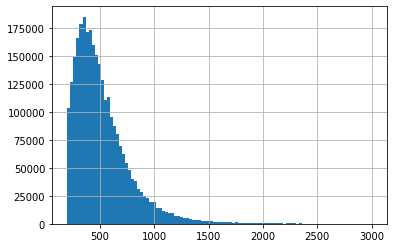

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5913
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5331
[100]	valid_0's huber: 64.9449
[150]	valid_0's huber: 58.7013
[200]	valid_0's huber: 54.9985
[250]	valid_0's huber: 52.5801
[300]	valid_0's huber: 50.7488
[350]	valid_0's huber: 49.3984
[400]	valid_0's huber: 48.3078
[450]	valid_0's huber: 47.4754
[500]	valid_0's huber: 46.6897
[550]	valid_0's huber: 45.9827
[600]	valid_0's huber: 45.3328
[650]	valid_0's huber: 44.7606
[700]	valid_0's huber: 44.2207
[750]	valid_0's huber: 43.7095
[800]	valid_0's huber: 43.3104
[850]	valid_0's huber: 42.8801
[900]	valid_0's huber: 42.4947
[950]	valid_0's huber: 42.1765
[1000]	valid_0's huber: 41.813
[1050]	valid_0's huber: 41.5187
[1100]	valid_0's huber: 41.2803
[1150]	valid_0's huber: 41.042
[1200]	valid_0's huber: 40.7795
[1250]	valid_0's huber: 40.5603
[1300]	valid_0's huber: 40.3737
[1350]	valid_0's huber: 40.156
[1400]	valid_0's huber: 39.9677
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


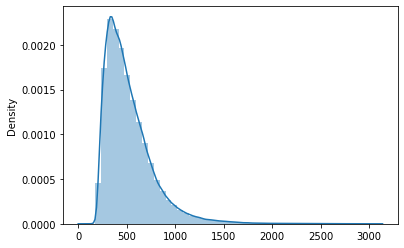

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [25]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_41_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.680767298021

In [28]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [29]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [30]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [31]:
shap_summary_df.index = x_train.columns

In [32]:
shap_summary_df.to_csv(basedir + 'shap_top_41.csv')

In [33]:
shap_summary_df.head(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.058814,93.599680,90.010205,94.337450,95.602837,93.321797
공시지가(만원),75.770672,77.786150,79.246323,75.407583,79.580994,77.558344
year_linear,63.010370,63.152728,64.733163,63.441504,64.620357,63.791624
건축년도,46.003550,50.425418,47.711136,49.073639,48.231282,48.289005
전용면적,37.853278,37.105692,38.188654,39.627534,40.736178,38.702267
ynorm,30.586887,30.520965,32.265034,29.938875,31.734174,31.009187
xy,22.010398,21.302770,20.232423,21.212108,21.167733,21.185086
x_2nd,18.967359,18.208714,18.728190,20.188932,19.567873,19.132214
주건축물수,14.245127,12.391786,13.432620,13.348851,14.085138,13.500704
층mean,11.179779,11.650586,10.523600,12.048457,10.518641,11.184212


In [34]:
shap_summary_df.tail(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
건물나이,2.358515,2.083967,2.283042,2.342069,2.337888,2.281096
옥외자주식대수,2.393124,2.062438,2.333365,2.078988,2.313434,2.236270
층min,1.983282,2.180167,2.066007,2.529952,2.221020,2.196086
(한강)폐기물매립시설_설치제한지역,2.329299,2.458032,2.236254,2.214971,2.192310,2.286173
공원,2.471808,2.577535,2.286046,2.264480,2.081741,2.336322
지형형상,1.419740,1.497682,1.268354,1.489291,1.516234,1.438260
y_cos,1.198884,1.547122,1.246939,1.155894,1.306677,1.291103
y_sin,1.172319,1.358741,1.279359,1.355262,1.357549,1.304646
x_sin,1.541229,1.386282,1.315988,1.445287,1.586248,1.455007
x_cos,1.311680,1.254782,1.141504,1.194151,1.347959,1.250015


In [35]:
#